In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.units as u
import datalab_utils
import time

from astropy.coordinates import SkyCoord
from dl import authClient as ac, queryClient as qc
from dl.helpers.utils import convert
from tqdm import tqdm

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
fig_dir = "/dlusers/adriansh/work/analyses/plots/strings/"

In [2]:
lmc_center = SkyCoord("05h23m34s", "−69d45.4m")
lmc_ra = lmc_center.ra.deg
lmc_dec = lmc_center.dec.deg
search_radius = 15
n_detections = 10
sigma_cutoff = 2.5 * np.log10(1.7)

In [21]:
oq = f"""
SELECT id 
    FROM nsc_dr2.object
        WHERE 't' = Q3C_RADIAL_QUERY(ra, dec, {lmc_ra}, {lmc_dec}, {search_radius})
        AND class_star > 0.9
        AND
        (CASE 
            WHEN ndetu > {n_detections} 
            AND urms < {sigma_cutoff} THEN 1 
            ELSE 0 
        END +
        CASE 
            WHEN ndetg > {n_detections} 
            AND grms < {sigma_cutoff}  THEN 1 
            ELSE 0 
        END +
        CASE 
            WHEN ndetr > {n_detections} 
            AND rrms < {sigma_cutoff}  THEN 1 
            ELSE 0 
        END +
        CASE 
            WHEN ndeti > {n_detections} 
            AND irms < {sigma_cutoff}  THEN 1 
            ELSE 0 
        END +
        CASE 
            WHEN ndetz > {n_detections} 
            AND zrms < {sigma_cutoff}  THEN 1 
            ELSE 0 
        END +
        CASE 
            WHEN ndetY > {n_detections} 
            AND Yrms < {sigma_cutoff}  THEN 1 
            ELSE 0 
        END >= 3)
"""

qq = f"""
SELECT ROW_NUMBER() OVER() - 1 AS row_number, id
    FROM mydb://temp
"""

qc.query(sql=qq, out="mydb://stable_lmc_ids", timeout=1200)

'OK'

In [16]:
bw = 2.5 * np.log10(2) / 4
# batch_size = int(1e5)
# n_objects = 6619504
# num_batches = int(n_objects / batch_size) + 1
# poll_rate = 60
# batch_nums = np.arange(0, num_batches)

sub_query = f"""
SELECT id
    FROM mydb://stable_lmc_ids 
    ORDER BY RANDOM()
    LIMIT 1000
"""

query = f"""
SELECT m.objectid, m.filter, m.mag_auto, m.magerr_auto, m.mjd, m.exposure, e.exptime
    FROM nsc_dr2.meas AS m
    INNER JOIN nsc_dr2.exposure AS e
    ON e.exposure = m.exposure
    WHERE m.objectid IN ({sub_query})
"""
lc = qc.query(sql=query, fmt="pandas", timeout=1200)
lc = lc.groupby(by=["objectid", "filter"]).filter(lambda x: len(x) > n_detections)
lc.sort_values(by="mjd", inplace=True)

In [17]:
def count_detections(df, dmag, n, bw):
    vals = df["filter"]
    indices = [vals[i:i+n].index for i in range(len(vals)- (n - 1)) if len(set(vals[i:i+n])) >= 2]
    n_lensed = len(indices)
    detected = [lens_and_detect(df, dmag, idxs, bw) for idxs in indices]
    n_detected = sum(detected)
    oid = df.iloc[0, 0]
    result = pd.DataFrame(data={"lensed": [n_lensed], "detected": [n_detected]}, index=[oid])
    return result

def lens_and_detect(df, dmag, idxs, bw):
    old_vals = df.loc[idxs, "mag_auto"]
    df.loc[idxs, "mag_auto"] = old_vals + dmag
    cl = datalab_utils.cluster_label_dataframe(df, bandwidth=bw, tolerance=(1.1, 10))
    df.loc[idxs, "mag_auto"] = old_vals
    result = datalab_utils.lens_filter(cl)
    return result

def calculate_detection_rate(df, delta_mag, n, bandwidth):
    injection_results = df.groupby(by="objectid", group_keys=False).apply(count_detections, delta_mag, n, bandwidth)
    totals = injection_results.sum(axis=0)
    result = totals["detected"] / totals["lensed"]
    return result

In [18]:
bw = 2.5 * np.log10(2) / 4
n_samples = 2
delta_mags = -np.linspace(0.1, 2.5, num=25)

In [ ]:
detection_rates_n2 = np.array([calculate_detection_rate(lc, dmag, n_samples, bw) for dmag in delta_mags])

In [ ]:
detection_rates_n3 = np.array([calculate_detection_rate(lc, dmag, 3, bw) for dmag in delta_mags])

In [7]:
# sums = detection_rates.sum(axis=1)
# detection_rates = sums[:, 1] / sums[:, 0]
stair_edges = np.concatenate(([0], delta_mags))

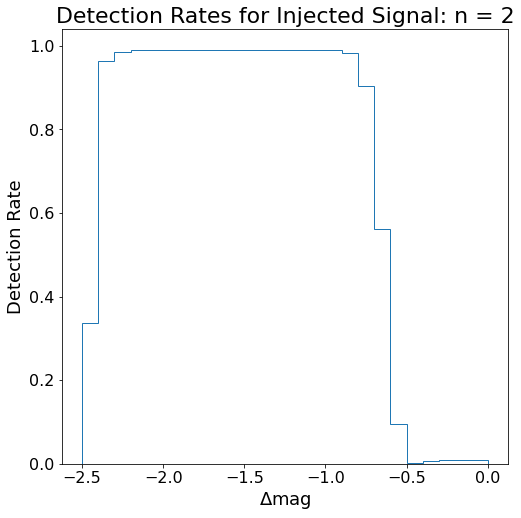

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.stairs(detection_rates, edges=stair_edges)
ax.set_title(f"Detection Rates for Injected Signal: n = {n_samples}", fontsize=22)
ax.set_ylabel("Detection Rate", fontsize=18)
ax.set_xlabel(r"$\Delta$mag", fontsize=18)
ax.tick_params(labelsize=16)
fig.savefig(f"{fig_dir}detection_rate_n2.png")
plt.show(fig)

In [9]:
detection_rates_3 = np.array([calculate_detection_rate(lc, dmag, 3, bw) for dmag in delta_mags])

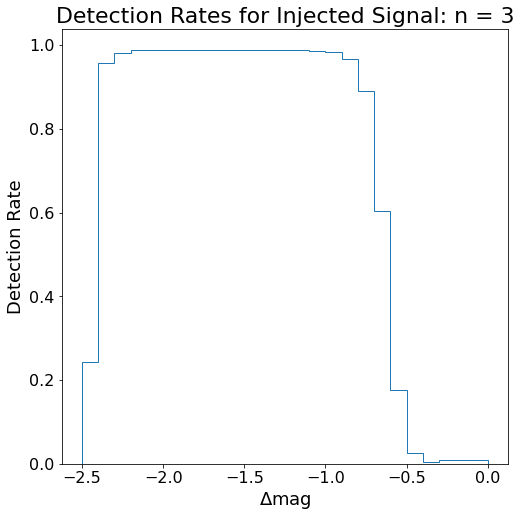

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.stairs(detection_rates_3, edges=stair_edges)
ax.set_title(f"Detection Rates for Injected Signal: n = 3", fontsize=22)
ax.set_ylabel("Detection Rate", fontsize=18)
ax.set_xlabel(r"$\Delta$mag", fontsize=18)
ax.tick_params(labelsize=16)
fig.savefig(f"{fig_dir}detection_rate_n3.png")
plt.show(fig)